## Validate observed vs. simulated yield
US Maize yield observations data source: USDA NASS

In [1]:
import os
import yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from palettable.colorbrewer.sequential import Purples_9
from palettable.colorbrewer.sequential import YlGn_9

from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype.nass_process import read_nass, nass_summarize
from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype import DATA_PATH

In [2]:
# Read in sim data
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_control_fixpd.yml')

In [3]:
# Read in site-years
df_siteyears = pd.read_csv(
    os.path.join(DATA_PATH, 'siteyears', 'siteyears_control_fixpd.csv'), dtype={'site':str})

In [4]:
# Filters for year, planting area, & irrigation level
year_start = 2005
year_end = 2012
area = 10000/2.47  # acre into ha
irri = 10

# Filter NASS data
df_nass_summary = nass_summarize(year_start, year_end)
df_sub = df_nass_summary.query(f'(area > {area}) & (perct_irri < {irri})')

# Upscale yield from plant level (g/plant) to field level (tons/ha)
pop = 8 # plants/m2
ha_to_m2 = 10000
ton_to_g = 1000000  # metric ton
yield_conv = 0.86  # only portion of ear converts into yield

### Visualize observed vs. simulated yield
Note that validation is made with more recent yield observations (2005-2012) although simulations are done with weather station data from 1961-2005. The rationale for this is mostly because the standard cultivar I used represents a more modern culivar along with modern day planting densities, so it makes more sense to compare to recent yields. <br/>
An alternative approach would be to remove planting density trends in past yield data since that contributes to a very large part of the positive yield trend in the past few decades. Still need to get changes in planting density data to do so.

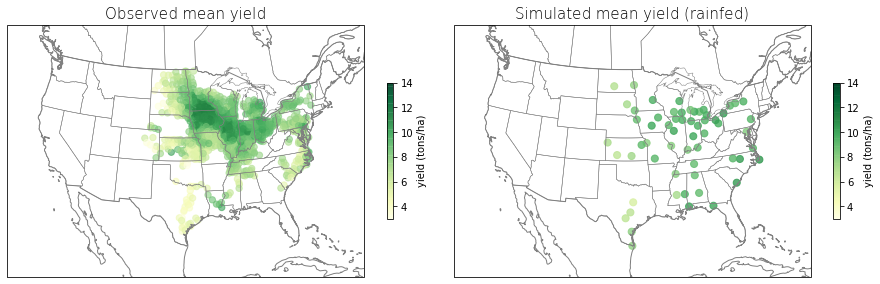

In [5]:
# Observed yield
fig = plt.figure(figsize=(16,5))
extent = [-123, -72, 19, 53]

ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))

ax1.set_extent([-123,-72,19,53])
mp1 = ax1.scatter(df_sub.lon, df_sub.lat, 
                  transform=ccrs.PlateCarree(),
                  c=df_sub['yield'],
                  s=40,
                  cmap=YlGn_9.mpl_colormap,
                  vmin=3, vmax=14, alpha=0.6)

ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Observed mean yield', fontsize=15, fontweight='light')
fig.colorbar(mp1, shrink=0.5, label='yield (tons/ha)')

# Sim yield
df_summary = df_all.groupby('site').mean()
sim_yield = [(ha_to_m2*pop*ear*yield_conv)/ton_to_g for ear in df_summary.dm_ear]
#sim_area = [area/700 for area in df_summary['area']]

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))

mp2 = ax2.scatter(df_summary.lon, df_summary.lat, 
                  transform=ccrs.PlateCarree(), 
                  c=sim_yield, 
                  cmap=YlGn_9.mpl_colormap,
                  alpha=0.8, vmin=3, vmax=14, s=50)
ax2.set_extent(extent)
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Simulated mean yield (rainfed)', fontsize=15, fontweight='light')
fig.colorbar(mp2, shrink=0.5, label='yield (tons/ha)')

fig.subplots_adjust(wspace=0, hspace=-0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/validate_maps_0512.png', format='png', dpi=800)

### Yield comparison with same points

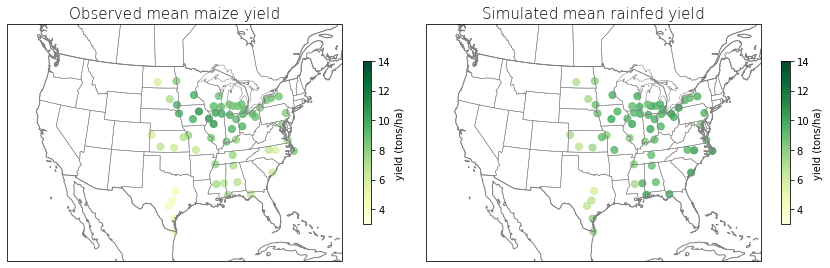

In [6]:
# Calculate average maize yield from NASS sites near sim sites
nass_yields = []

for item in np.arange(df_sites.shape[0]):
    lat = df_sites.iloc[item]['lat']
    lon = df_sites.iloc[item]['lon']
    
    dist = list(enumerate(
        np.sqrt((lat - df_sub.lat)**2 + (lon - (df_sub.lon))**2)))
    df_dist = pd.DataFrame(dist, columns=['rownum', 'distance'])
    rows = list(df_dist.nsmallest(10, 'distance').rownum)
    nass_yield = round(df_sub.iloc[rows]['yield'].mean(),2)
    nass_yields.append(nass_yield)
    

# Observed yield
fig = plt.figure(figsize=(15,6))
extent = [-123, -72, 19, 53]

ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123,-72,19,53])
mp1 = ax1.scatter(df_sites.lon, df_sites.lat, 
                  transform=ccrs.PlateCarree(),
                  c=nass_yields,
                  cmap=YlGn_9.mpl_colormap,
                  alpha=0.8, vmin=3, vmax=14, s=50)

ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Observed mean maize yield', fontsize=15, fontweight='light')
fig.colorbar(mp1, shrink=0.5, label='yield (tons/ha)')

# Sim yield
ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
sim_yield = [(ha_to_m2*pop*ear*yield_conv)/ton_to_g for ear in df_summary.dm_ear]

mp2 = ax2.scatter(df_summary.lon, df_summary.lat, 
                  transform=ccrs.PlateCarree(), 
                  c=sim_yield, 
                  cmap=YlGn_9.mpl_colormap,
                  alpha=0.8, vmin=3, vmax=14, s=50)
ax2.set_extent(extent)
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Simulated mean rainfed yield', fontsize=15, fontweight='light')
fig.colorbar(mp2, shrink=0.5, label='yield (tons/ha)')

fig.subplots_adjust(wspace=0, hspace=-0.8)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/validate_map_sameloc_0512.png', format='png', dpi=800)

### Yield validation one-to-one plots

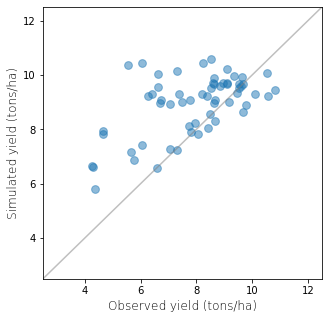

In [7]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

ax.scatter(nass_yields, sim_yield, alpha=0.5, s=60)
ax.set_xlim(2.5,12.5)
ax.set_ylim(2.5,12.5)
ax.axline((1, 1), slope=1, color='grey', alpha=0.5)

plt.xlabel('Observed yield (tons/ha)', fontweight='light', fontsize=12)
plt.ylabel('Simulated yield (tons/ha)', fontweight='light', fontsize=12)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/validate_scatter_0512.png', format='png', dpi=800)